# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Имопртируем необходимые библиотеки и классы

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, roc_auc_score
)

from sklearn.preprocessing import StandardScaler

## Загрузка и подготовка данных

In [2]:
try:
    data0 = pd.read_csv('path_to/geo_data_0.csv')
    data1 = pd.read_csv('path_to/geo_data_1.csv')
    data2 = pd.read_csv('path_to/geo_data_2.csv')
    print('Прочитали данные с диска')
except:
    data0 = pd.read_csv('/datasets/geo_data_0.csv')
    data1 = pd.read_csv('/datasets/geo_data_1.csv')
    data2 = pd.read_csv('/datasets/geo_data_2.csv')
    print('Прочитали данные в сети')

Прочитали данные в сети


Называть датасеты далее буду по индексам (нулевой, первый, второй).

Посмотрим общую информацию по датасетам

In [3]:
display(data0.info())
display(data0.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
display(data1.info())
display(data1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
display(data2.info())
display(data2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Пропусков нет. Тип данных везде один. Поле ID скважины будет не нужно.

Посмотрим распределение значений

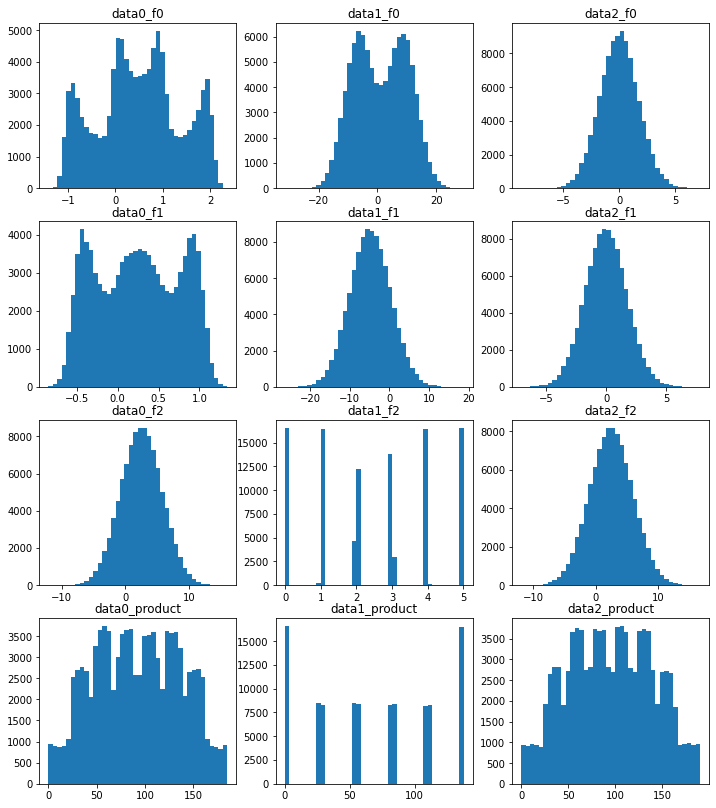

In [6]:
figure, axis = plt.subplots(4, 3, figsize=(12,14))
for c in range(4):
    col = 'f'+str(c)
    if c==3:
        col = 'product'
    for d in range(3):
        da = 'data'+str(d)
        axis[c,d].hist(eval(da)[col],bins=40)
        axis[c,d].set_title(da+'_'+col)
plt.show();

Все датафреймы заметно отличаются друг от друга. При этом похоже, что поля f2 и proruct в data1 имеют дискретные значения

In [7]:
display(data1['product'].nunique())
data1['f2'].nunique()

12

100000

Значения в поле f2 не ранговые, но варируются вокруг определенных рангов.

Поле product действительно ранговое.

Посмотрим матрицы корреляции

In [8]:
data0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


Отметим
- условно среднюю обратную зависимость между f0 и f1 (с какого уровня начинается мультиколлинеарность? Пишут, что "На практике пороговое значение зависит от задачи и находится в диапазоне от 0.6 до 1.0". Поэтому пока не предпринимаю никаких действий)
- условно среднюю прямую зависимость между f2 и product.

In [9]:
data1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Отметим сильную (почти 100%-ную) прямую зависимость между f2 и product. Т.о., теоретически для прогноза в этом датасете можно использовать только один признак f2

In [10]:
data2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'> Значимость коэффициентов корреляции для нашего текущего проекта - в возможности определить наличие / отсутствие мультиколлинеарности между признаками для целей использования / отбрасывания определенных признаков подаваемых на вход линейной модели, которая задается линейным уравнением w1*X1+w2*X2 ... (Х1, Х2 - признаки) Т.к. в случае мультиколлинеарности между признаками мы имеем Х1=а*Х2+Ь. Что при наличии в наборе подаваемом в линейную модель обоих: и Х1, и Х2, не позволяет этой модели однозначно рассчитать веса w1 w2 (глупая модель, однако.. ведь почему бы не заложить в алгоритм модели проверку муьтиколл-ти и установку например w2=0, либо представить уравнение как: w1*(а*Х2+Ь) + w2*Х2)
   </font>
</div>

In [11]:
data0.drop(['id'], axis=1).duplicated().sum()

0

In [12]:
data1.drop(['id'], axis=1).duplicated().sum()

0

In [13]:
data2.drop(['id'], axis=1).duplicated().sum()

0

Отметим условно среднюю прямую зависимость между f2 и product

Поскольку работаем с линейной регрессией, необходимо отмасштабировать значения признаков. Предварительно разделим выборку.

Выборку разделю на train (75%), valid (25%).

In [14]:
features0 = data0.drop(['id','product'], axis=1)
target0 = data0['product']
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
        features0, target0, test_size=0.25, random_state=12345)

features1 = data1.drop(['id','product'], axis=1)
target1 = data1['product']
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
        features1, target1, test_size=0.25, random_state=12345)

features2 = data2.drop(['id','product'], axis=1)
target2 = data2['product']
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
        features2, target2, test_size=0.25, random_state=12345)

In [15]:
# Создадим списки с названиями полей для признаков и целевого поля
fit_list = ['f0','f1','f2']
targ_list = ['prodict']

In [16]:
# функция обучения и получения метрик и предсказаний
def model_out(features_train,target_train,features_valid,target_valid):
    # инициализируем модель с ГП по умолчанию
    model = LinearRegression()

    # "обучим" скалер и отмасштабируем признаки
    stand_scaler_train = StandardScaler()
    stand_scaler_train.fit_transform(features_train[fit_list])
    features_valid[fit_list] = stand_scaler_train.transform(features_valid[fit_list])
    
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    pred_series = pd.Series(predictions_valid,index=target_valid.index)
    #f1 = f1_score(target_valid, predictions_valid)
    #accuracy = accuracy_score(target_valid,predictions_valid)
    #recall = recall_score(target_valid,predictions_valid)
    #precission = precision_score(target_valid,predictions_valid)
    mse = mean_squared_error(target_valid,predictions_valid)
    rmse = mse**0.5
    return rmse, pred_series

In [17]:
# обучим модели и получим значения метрик и предсказания
rmse_0, pred_0 = model_out(features_train_0,target_train_0,features_valid_0,target_valid_0)
rmse_1, pred_1 = model_out(features_train_1,target_train_1,features_valid_1,target_valid_1)
rmse_2, pred_2 = model_out(features_train_2,target_train_2,features_valid_2,target_valid_2)

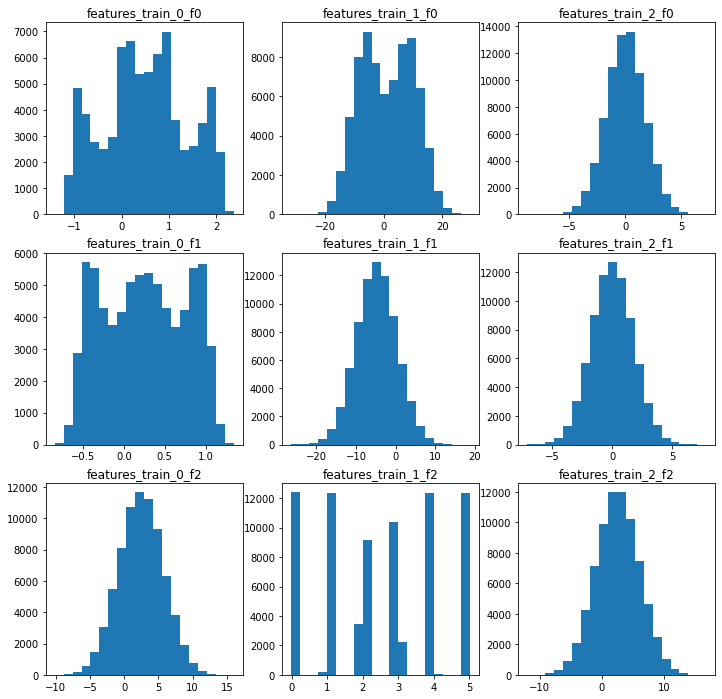

In [18]:
# посмотрим получившиеся распределения
figure, axis = plt.subplots(3, 3, figsize=(12,12))
for c in range(3):
    col = 'f'+str(c)
    for d in range(3):
        da = 'features_train_'+str(d)
        #print(da,col)
        axis[c,d].hist((eval(da)[col]),bins=20)
        axis[c,d].set_title(da+'_'+col)
plt.show()

Формы распределений не изменились, значения распределились вокруг нуля.

## Обучение и проверка модели

Оптимизировать гиперпараметры в линейной регрессии, очевидно, нет необходимости. Обучим модели.

In [19]:
print('Регион 0 - Средние предсказанные запасы:',round(pred_0.mean(),2),' // RMSE: ',rmse_0.round(3))
print('Регион 1 - Средние предсказанные запасы:',round(pred_1.mean(),2),' // RMSE: ',rmse_1.round(3))
print('Регион 2 - Средние предсказанные запасы:',round(pred_2.mean(),2),' // RMSE: ',rmse_2.round(3))

Регион 0 - Средние предсказанные запасы: 77.87  // RMSE:  43.407
Регион 1 - Средние предсказанные запасы: 1.58  // RMSE:  69.791
Регион 2 - Средние предсказанные запасы: 80.76  // RMSE:  44.898


Получили лучшие показатели по предсказанным запасам в регионах 0 и 2. При этом качество модели лучшее в регионе 1. Это было понятно из наличия 100% прямой зависимости между f2 и product. 

## Подготовка к расчёту прибыли

In [20]:
# сохраним ключевые значения для расчётов
selection_size = 500 # кол-во точек для исследования
dev_size = 200 # количество лучших для разработки
total_costs = 10_000_000_000 # бюджет в рублях на разработку в целом по региону
revenue_per_barr = 450_000 # доход в рублях с единицы product
loss_proba_cutoff = 0.025 # отсечка по вероятности убытков в целом по региону

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [21]:
# costs(i)  = total_costs/dev_size         -- средние расходы (бюджет) на разработку одной скважины
# income(i) = revenue_per_barr*product(i)  -- планируемый общий доход с одной скважины
# income(i) - costs(i) >= 0                -- безубыточная разработка
# product_cutoff = total_costs/(revenue_per_barr*dev_size) -- достаточный объём сырья
product_cutoff = total_costs/(revenue_per_barr*dev_size)
print('Безубыточный объём сырья:',round(product_cutoff,2))

Безубыточный объём сырья: 111.11


Видим, что средние предсказанные запасы во всех регионах заметно меньше безубыточного уровня.

In [22]:
print('Средний объем запасов в регионе 0:',round(target0.mean(),2),
' - отличается от средних предсказанных в',round((target0.mean()-pred_0.mean())/target0.mean(),4),'раз')
print('Средний объем запасов в регионе 1:',round(target1.mean(),2),
' - отличается от средних предсказанных в',round((target1.mean()-pred_1.mean())/target1.mean(),4),'раз')
print('Средний объем запасов в регионе 2:',round(target2.mean(),2),
' - отличается от средних предсказанных в',round((target2.mean()-pred_2.mean())/target2.mean(),4),'раз')

Средний объем запасов в регионе 0: 92.5  - отличается от средних предсказанных в 0.1582 раз
Средний объем запасов в регионе 1: 68.83  - отличается от средних предсказанных в 0.9771 раз
Средний объем запасов в регионе 2: 95.0  - отличается от средних предсказанных в 0.1499 раз


<div class="alert alert-warning">
<font size="4"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
<u>Контрольный вопрос:</u>

Когда ты выведешь на экран средние истинные запасы, то увидишь, что они одинаково близки к средним предсказанным как в регионе 1, где очень низкий RMSE, так и в регионах с RMSE около 40. Как ты это объяснишь?

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'> Оъясняется это симметричной формой распределений значений запасов. По сути наш линейный предикт для симметричного распределения и будет средним фактического таргета. Ну или вообще это характерно для линейной регрессии (не готов сейчас проверять, но для симметрии - это интуитивно понятно), поскольку мы "прокладываем" линию регрессии на основе метода наименьших квадратов расстояний от факт.точек до линии, соответственно сама линия и будет средним (точнее среднеквадратичным) для факта.
   </font>
</div>

Видим, что просто ориенироваться на средние запасы нельзя. На данном этапе определить прибыльный регион также нельзя

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [23]:
def selected_wells_margin(selected_predict_series, target_valid
                        #,dev_size=200 # dev_size - количество лучших скважин для разработки
                        #,revenue_per_barr=450_000
                        #,total_costs=10_000_000
                         ):
    idx = selected_predict_series.nlargest(200).index
    selected_target = target_valid[idx]
    selected_wells_margin = (selected_target.sum()*revenue_per_barr)-total_costs
    return selected_wells_margin

Напишем функцию для поиска среднего значения прибыли и доверительного интервала по бутстрапированной выборке.

Поскольку финансовый результат (прибыль/убыток) мы можем посчитать только в целом по региону как "общий доход с 200 выбранных скважин -(минус) бюджет(10млрд)",

поэтому риск убытков будем считать как отношение количества раз, когда, используя бутсрап, на подвыборке мы получили отрицательный фин.рез. к количеству сделанных подвыборок (1000)

In [24]:
state = RandomState(12345)
def bootsrap_pred(predicted_target_series, target_valid
                #,selection_size=500 # selection_size - кол-во точек для исследования
                                                # predicted - массив model.predict(features_valid)
                #,revenue_per_barr=450_000
                #,total_costs=10_000_000
                 ): 
                                                 
    bootstraped_margin = [] # значение прибыли по региону для бутрапированной выборки
    #predicted = pd.Series(predicted)
    for i in range(1000):
        # берем подвыборку из predicted
        subsample = predicted_target_series.sample(n=500,
                                     replace=True, random_state=state)
        # считаем фин.результат по региону для подвыборки
        swm = selected_wells_margin(subsample, target_valid)
        bootstraped_margin.append(swm)
    bootstraped_margin = pd.Series(bootstraped_margin)
    mean_margin = bootstraped_margin.mean() # среднее значение фин. результата
    lower = bootstraped_margin.quantile(0.025) # нижняя граница для 95% дов.интервала
    upper = bootstraped_margin.quantile(0.975) # верхняя граница для 95% дов.интервала
    loss_proba = ((bootstraped_margin<0).sum())/1000 # вероятность убытков
    return mean_margin, lower, upper, loss_proba, bootstraped_margin

Посмотрим, что получается по регионам. Значения прибыли переведем в миллионы

In [26]:
mean_margin_0, lower_0, upper_0, loss_proba_0, marg_0 = bootsrap_pred(pred_0, target_valid_0)
print('Средняя прибыль:',round(mean_margin_0/1_000_000,3),
      ' // 2,5% квантиль:',round(lower_0/1_000_000,3),
      ' // 97,5% квантиль:',round(upper_0/1_000_000,3),
      ' // вероятность убытков:',loss_proba_0)

Средняя прибыль: -314.302  // 2,5% квантиль: -835.565  // 97,5% квантиль: 214.368  // вероятность убытков: 0.866


In [27]:
mean_margin_1, lower_1, upper_1, loss_proba_1, marg_1 = bootsrap_pred(pred_1, target_valid_1)
print('Средняя прибыль:',round(mean_margin_1/1_000_000,3),
      ' // 2,5% квантиль:',round(lower_1/1_000_000,3),
      ' // 97,5% квантиль:',round(upper_1/1_000_000,3),
      ' // вероятность убытков:',loss_proba_1)

Средняя прибыль: 458.77  // 2,5% квантиль: 76.62  // 97,5% квантиль: 862.952  // вероятность убытков: 0.007


In [28]:
mean_margin_2, lower_2, upper_2, loss_proba_2, marg_2 = bootsrap_pred(pred_2, target_valid_2)
print('Средняя прибыль:',round(mean_margin_2/1_000_000,3),
      ' // 2,5% квантиль:',round(lower_2/1_000_000,3),
      ' // 97,5% квантиль:',round(upper_2/1_000_000,3),
      ' // вероятность убытков:',loss_proba_2)

Средняя прибыль: 392.47  // 2,5% квантиль: -111.839  // 97,5% квантиль: 930.083  // вероятность убытков: 0.064


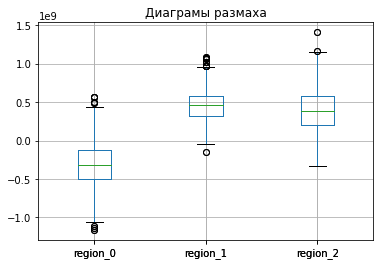

In [29]:
margin = pd.DataFrame({'region_0':marg_0,'region_1':marg_1,'region_2':marg_2})
margin.boxplot()
margin.boxplot().set_title('Диаграмы размаха');

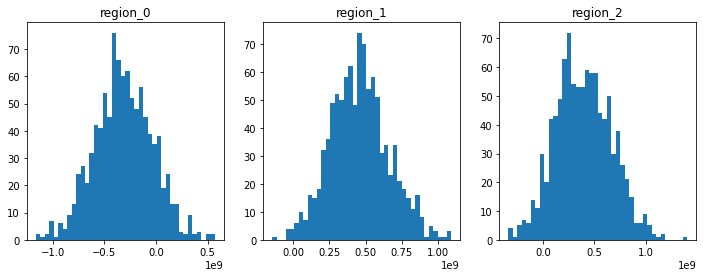

In [30]:
figure, axis = plt.subplots(1, 3, figsize=(12,4))
for i in range(3):
    reg, low, upp = 'region_'+str(i), 'lower_'+str(i), 'upper_'+str(i)
    axis[i].hist(margin[reg],bins=40)
    axis[i].set_title(reg)
    #axis[i].axis([margin[reg].min(),margin[reg].max(),0,100])
    #axis[i].axvline(x=low,color='g',label='2.5%')
    #axis[i].axvline(x=upp,color='r',label='97.5%')
    #axis[i].legend()
plt.show();

Не смог  воткнуть вертикальные линии кватилей на график - мое кунг-фу пока не такое сильное.. Что то посмотрел в сети и не шмог. Буду признателен, если подскажешь как это сделать.

Видим, что вероятность убытков при разработке 200 лучших скважин, определенных на основании предсказаний нашей модели, имеет значение менее 2,5% только в 1-м регионе. При этом для первого региона значения средней прибыли и медианы (как видно из ящика с усами) выше других регионов.
Т.о. наиболее привлекательным для разработки является 1-й регион (geo_data_1)